#TP07

In [2]:
try:
 # %tensorflow_version only exists in Colab.
 %tensorflow_version 2.x 
except Exception:
 pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


###We will normalize all values between 0 and 1 and we will flatten the 28×28 images into vectors of size 784.

In [4]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


Premier **General** autoencodeur

In [26]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations
encoding_dim = 16  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

2nd ver

In [ ]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model: this model maps an input to its encoded representation

In [28]:
encoder = Model(input_img, encoded)

As well as the decoder model:

In [29]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [30]:
autoencoder.compile(optimizer='adam', loss='mse')

In [18]:
autoencoder.fit(x_train, x_train,
                epochs=60,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/60
235/235 [==============================] - 2s 4ms/step - loss: 0.0803 - val_loss: 0.0503
Epoch 2/60
235/235 [==============================] - 1s 4ms/step - loss: 0.0436 - val_loss: 0.0380
Epoch 3/60
235/235 [==============================] - 1s 3ms/step - loss: 0.0354 - val_loss: 0.0324
Epoch 4/60
235/235 [==============================] - 1s 3ms/step - loss: 0.0309 - val_loss: 0.0289
Epoch 5/60
235/235 [==============================] - 1s 4ms/step - loss: 0.0282 - val_loss: 0.0268
Epoch 6/60
235/235 [==============================] - 1s 4ms/step - loss: 0.0266 - val_loss: 0.0256
Epoch 7/60
235/235 [==============================] - 1s 5ms/step - loss: 0.0256 - val_loss: 0.0248
Epoch 8/60
235/235 [==============================] - 1s 5ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 9/60
235/235 [==============================] - 1s 4ms/step - loss: 0.0242 - val_loss: 0.0235
Epoch 10/60
235/235 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0230

We can try to visualize the reconstructed inputs and the encoded representationslib.

In [31]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


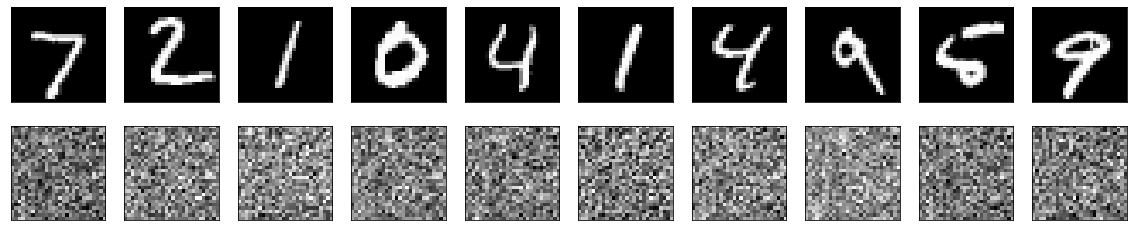

In [32]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Denoising ATE**

In [33]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [34]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

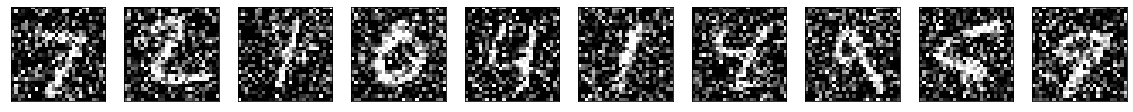

In [35]:
n =10 
plt.figure(figsize= (20, 2)) 
for i in range (n):
    ax = plt.subplot (1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28)) 
    plt.gray () 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [37]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/100
469/469 [==============================] - 11s 8ms/step - loss: 0.6723 - val_loss: 0.6595
Epoch 2/100
469/469 [==============================] - 5s 10ms/step - loss: 0.6395 - val_loss: 0.6155
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5812 - val_loss: 0.5479
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5219 - val_loss: 0.5089
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5000 - val_loss: 0.4987
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4916 - val_loss: 0.4913
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4842 - val_loss: 0.4836
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4760 - val_loss: 0.4748
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4670 - val_loss: 0.4652
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4569 - val_

313/313 [==============================] - 1s 2ms/step


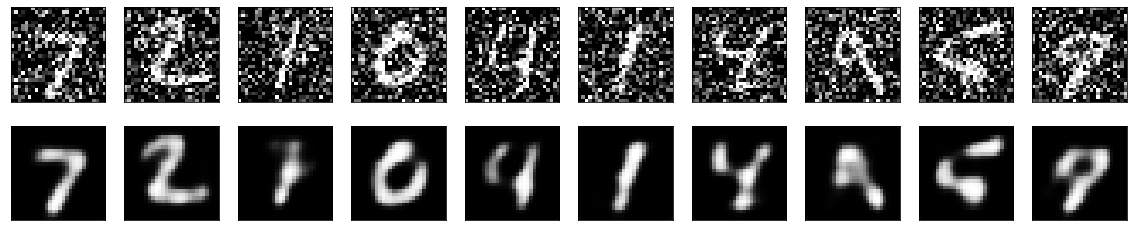

In [38]:

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()